In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1005. Miscellaneous Analyses/P1005.5. Yael RNAseq Grant/P1005.5.3. Analyses/P1005.5.3.1 DESeq2/Output')
cur_date = "010824"

library(readxl)
library(openxlsx)
library(tidyverse)
library(reshape2)
library(data.table)
library(factoextra)
library(ggrepel)
library(pheatmap)
library(DESeq2)

# reading in files
counts_df = data.frame(read_excel("Input/Yael_Counts_120223.xlsx")) 
subject_info_df = data.frame(read_excel("Input/SubjectInfo_120223.xlsx", sheet = 2))
asthma_gene_list_df = data.frame(read_excel("Input/Paper Gene List.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from

In [2]:
head(counts_df)
head(subject_info_df)
head(asthma_gene_list_df)

,Gene,X1911_1,X1911_19,X1911_2,X1911_20,X1911_21,X1911_22,X1911_3,X1911_4,X1911_55,⋯,X2009_14,X2009_15,X2009_2,X2009_3,X2009_4,X2009_5,X2009_6,X2009_7,X2009_8,X2009_9
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CHAC1_1279,56,20,12,22,12,25,23,17,27,⋯,57,90,14,18,33,46,17,15,36,13
2,GLRX_2674,124,581,356,358,661,657,304,561,421,⋯,530,462,599,503,677,272,447,477,475,454
3,MEFV_4116,0,0,0,0,0,1,5,0,3,⋯,0,0,0,4,0,0,0,1,0,0
4,STXBP1_6866,55,95,172,120,121,77,200,97,85,⋯,109,99,121,92,71,132,136,143,165,183
5,AKAP8L_196,93,37,35,28,50,26,41,24,33,⋯,84,53,32,20,51,26,28,34,36,33
6,AKR1C1_199,670,723,513,415,1112,418,559,385,767,⋯,836,492,642,524,381,185,546,529,214,400


,Original_Sample_ID,Original_Subject_No,Subject_No,Subject_ID,Sample_ID,Replicate,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,X1911_62,NBL 190,1,AS_1,AS_1_C.1,1,F,B,NH,47,23.7,AS,C,Air
2,X1911_56,NBL 190,1,AS_1,AS_1_F.1,1,F,B,NH,47,23.7,AS,F,PGGLY
3,X1911_20,NBL 190,1,AS_1,AS_1_C.2,2,F,B,NH,47,23.7,AS,C,Air
4,X1911_2,NBL 190,1,AS_1,AS_1_S.1,1,F,B,NH,47,23.7,AS,S,PGGLY
5,X1911_64,NBL 193,2,AS_2,AS_2_C.1,1,F,W,NH,19,19.5,AS,C,Air
6,X1911_58,NBL 193,2,AS_2,AS_2_F.1,1,F,W,NH,19,19.5,AS,F,PGGLY


,Gene.Symbol,k,Hedges.g,std.error,tau.2,z.value,p.value,q.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CEACAM5,8,1.0939910,0.1100273,0.01261454,9.942911,2.71e-23,1.00e-18
2,C3,8,-0.8490307,0.0983399,0.00000000,-8.633633,5.94e-18,1.10e-13
3,MUC5AC,7,0.8086030,0.1008032,0.00000000,8.021602,1.04e-15,1.29e-11
4,FUT3,8,0.7626832,0.0976211,0.00000000,7.812685,5.60e-15,5.17e-11
5,TCN1,7,0.7701838,0.1001925,0.00000000,7.687039,1.51e-14,9.33e-11
6,DQX1,8,0.7491184,0.0976080,0.00000000,7.674763,1.66e-14,9.33e-11


Using DESeq2 to determine if there are genes differentially expression after exposure to nicotine products in asthmatics vs. control subjects.

In [3]:
# first replacing the column names in the count df with sample ids that are more descriptive of the subjects
# also filtering for asthma genes
counts_df = counts_df %>%
    separate(Gene, sep = "_", c("Gene", NA)) %>%
    # only subsetting for asthma genes we're interested in 
    filter(Gene %in% asthma_gene_list_df$Gene.Symbol)
    # column_to_rownames(var = "Gene") %>%
    # # reordering cols so that they match the order in the subject info df
    # relocate(subject_info_df$Original_Sample_ID) 

colnames(counts_df)[2:40] = subject_info_df$Sample_ID
head(counts_df)

,Gene,AS_1_C.1,AS_1_F.1,AS_1_C.2,AS_1_S.1,AS_2_C.1,AS_2_F.1,AS_2_C.2,AS_2_S.1,AS_3_C.1,⋯,NAS_8_C.2,NAS_8_S.1,NAS_9_C.1,NAS_9_F.1,NAS_9_C.2,NAS_9_S.1,NAS_10_C.1,NAS_10_F.1,NAS_10_C.2,NAS_10_S.1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,STXBP1,55,95,172,120,121,77,200,97,85,⋯,109,99,121,92,71,132,136,143,165,183
2,CTSL,479,141,170,224,212,192,298,164,159,⋯,206,231,254,108,184,131,266,165,162,228
3,ALDH18A1,68,22,40,27,19,29,19,18,27,⋯,37,42,30,29,22,14,38,32,24,36
4,ECH1,67,24,0,0,24,23,48,47,32,⋯,19,33,36,26,26,59,22,10,64,45
5,C3,5037,1916,1268,1344,1551,422,776,301,1684,⋯,1446,1800,1031,353,2298,75,914,635,106,602
6,CASP7,1500,728,1046,964,930,770,1051,800,926,⋯,1033,656,854,814,624,685,1004,904,871,894


In [4]:
# pivoting longer to average the duplicate and replicate control samples
longer_counts_df = counts_df %>%
    #rownames_to_column(var = "Gene") %>%
    pivot_longer(cols = 2:40, names_to = "Sample_ID", values_to = "Value") %>%
    # averaging count data across the duplicate genes
    group_by(Gene, Sample_ID) %>%
    summarize(Value = mean(Value)) %>%
    # averaging count data across the replicate genes
    inner_join(subject_info_df[5:6]) %>%
    separate(Sample_ID, sep = "\\.", c("Sample_ID", NA)) %>%
    group_by(Gene, Sample_ID) %>%
    summarize(Value = mean(Value))

head(longer_counts_df)

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.


Gene,Sample_ID,Value
<chr>,<chr>,<dbl>
A2M,AS_1_C,0
A2M,AS_1_F,0
A2M,AS_1_S,0
A2M,AS_2_C,0
A2M,AS_2_F,0
A2M,AS_2_S,0


In [5]:
# checking for duplicates
Dups = duplicated(longer_counts_df)
summary(Dups)

   Mode   FALSE 
logical   33690 

No duplicates. Now creating dataframes that are formatted for proceeding code, as well as DESeq2 functions.

In [6]:
# first creating a `coldata` object that contains all the metadata for each sample
coldata = subject_info_df[,c(4:5,6:14)] %>%
    separate(Sample_ID, sep = "\\.", c("Sample_ID", NA)) %>%
    select(-Replicate) %>%
    unique()

head(coldata)

,Subject_ID,Sample_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,AS_1,AS_1_C,F,B,NH,47,23.7,AS,C,Air
2,AS_1,AS_1_F,F,B,NH,47,23.7,AS,F,PGGLY
4,AS_1,AS_1_S,F,B,NH,47,23.7,AS,S,PGGLY
5,AS_2,AS_2_C,F,W,NH,19,19.5,AS,C,Air
6,AS_2,AS_2_F,F,W,NH,19,19.5,AS,F,PGGLY
8,AS_2,AS_2_S,F,W,NH,19,19.5,AS,S,PGGLY


In [7]:
# making a `countdata` obj that contains genes as rows and sample names as cols
countdata = longer_counts_df %>%
    pivot_wider(names_from = "Sample_ID", values_from = "Value") %>%
    column_to_rownames(var = "Gene")

head(countdata)

,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,AS_4_C,⋯,NAS_10_S,NAS_7_C,NAS_7_F,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M,0.0,0,0,0.0,0,0,0.75,0,0,0,⋯,0,0.0,0.5,0,0.0,0,0.5,0.0,0,0
A4GALT,4108.5,2986,4169,3063.0,4008,3853,3457.00,4976,3506,3027,⋯,3628,4643.5,2837.0,3045,3745.5,2825,3028.0,2884.5,5519,3161
AADAC,2.0,14,5,10.5,25,13,37.00,7,19,10,⋯,69,74.5,103.0,32,26.5,32,30.0,47.5,28,70
AADAT,7.0,7,7,8.5,1,4,11.50,5,9,6,⋯,26,8.5,13.0,3,11.0,19,14.0,14.5,7,8
ABCA13,232.5,94,85,76.0,298,260,191.00,95,362,120,⋯,161,243.5,294.0,60,179.5,134,30.0,84.5,110,349
ABCB7,17.5,29,14,37.5,17,14,26.00,29,21,21,⋯,24,46.0,42.0,24,25.5,22,28.0,21.5,38,42


In [8]:
# checking for duplicates
summary(duplicated(coldata))
summary(duplicated(countdata))

# getting dimensions
dim(coldata)
dim(countdata)

   Mode   FALSE 
logical      30 

   Mode   FALSE    TRUE 
logical    1115       8 

[1] 30 10

[1] 1123   30

In [11]:
# checking duplicates
dups = rownames(countdata)[duplicated(countdata)]
countdata[dups,]

,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,AS_4_C,⋯,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD28,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CYLC2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GSC2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IL13,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MEF2C,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
PRB4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
SIGLEC6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
SNCB,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


These are considered duplicates since all the data contains zeros, but the df doesn't actually contain duplicate genes or columns. 

In [13]:
# Set the rownames of coldata and column names of countdata to be in the same order 
countdata <- setcolorder(countdata, as.character(coldata$Sample_ID))

head(countdata)

,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,AS_4_C,⋯,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M,0.0,0,0,0.0,0,0,0.75,0,0,0,⋯,0,0.0,0,0.5,0.0,0,0,0.0,0,0
A4GALT,4108.5,2986,4169,3063.0,4008,3853,3457.00,4976,3506,3027,⋯,3045,3745.5,2825,3028.0,2884.5,5519,3161,3856.0,4939,3628
AADAC,2.0,14,5,10.5,25,13,37.00,7,19,10,⋯,32,26.5,32,30.0,47.5,28,70,82.0,12,69
AADAT,7.0,7,7,8.5,1,4,11.50,5,9,6,⋯,3,11.0,19,14.0,14.5,7,8,21.0,9,26
ABCA13,232.5,94,85,76.0,298,260,191.00,95,362,120,⋯,60,179.5,134,30.0,84.5,110,349,313.5,95,161
ABCB7,17.5,29,14,37.5,17,14,26.00,29,21,21,⋯,24,25.5,22,28.0,21.5,38,42,46.0,30,24


In [15]:
# Double checking that the same variables appear between the two dataframes
setequal(as.character(coldata$Sample_ID), colnames(countdata))

# Additionally checking that not only the sets of variables are the same, but that they are in the same order
identical(as.character(coldata$Sample_ID), colnames(countdata))

[1] TRUE

[1] TRUE

# Transcriptomics QA/QC 
Performed on raw count data to identify potential outlier samples. Starting by filtering lowly expressed genes.

In [16]:
# First count the total number of samples and save it as a value in the global environment
nsamp <- ncol(countdata)

# Then, calculate the median expression level across all genes and all samples and save it as a value
total_median <- median(as.matrix(countdata), na.rm = TRUE)

# We need to temporarily add back in the gene column to the countdata 
# so we can filter for genes that pass the background filter
countdata <- countdata %>% 
    rownames_to_column("Gene")

head(countdata)

,Gene,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,⋯,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A2M,0.0,0,0,0.0,0,0,0.75,0,0,⋯,0,0.0,0,0.5,0.0,0,0,0.0,0,0
2,A4GALT,4108.5,2986,4169,3063.0,4008,3853,3457.00,4976,3506,⋯,3045,3745.5,2825,3028.0,2884.5,5519,3161,3856.0,4939,3628
3,AADAC,2.0,14,5,10.5,25,13,37.00,7,19,⋯,32,26.5,32,30.0,47.5,28,70,82.0,12,69
4,AADAT,7.0,7,7,8.5,1,4,11.50,5,9,⋯,3,11.0,19,14.0,14.5,7,8,21.0,9,26
5,ABCA13,232.5,94,85,76.0,298,260,191.00,95,362,⋯,60,179.5,134,30.0,84.5,110,349,313.5,95,161
6,ABCB7,17.5,29,14,37.5,17,14,26.00,29,21,⋯,24,25.5,22,28.0,21.5,38,42,46.0,30,24


In [19]:
# filtering for genes that have an expression greater than the total median in at least 20% of the samples
genes_above_background <- countdata %>% 
    pivot_longer(cols =! Gene, names_to = "sampleID", values_to = "expression") %>% 
    # indicates whether the expression of a gene for the corresponding exposure condition is above (1) or not 
    # above (0) the median of all count data
    mutate(above_median = ifelse(expression > total_median, 1, 0)) %>% 
    group_by(Gene) %>% 
    # For each gene, count the number of exposure conditions where the expression was greater than the median 
    # of all count data
    summarize(total_above_median = sum(above_median)) %>% 
    # Filter for genes that have expression above the median in at least 20% of the samples
    filter(total_above_median >= 0.2*nsamp) %>% 
    select(Gene) 

# Then filter the original 'countdata' dataframe for only the genes above background. 
countdata <- left_join(genes_above_background, countdata, by = "Gene")

dim(countdata)

[1] 626  31

This dataframe went from having 1,123 genes to 626 genes. Now filtering samples with no expression. 

In [21]:
countdata_T <- countdata %>% 
  pivot_longer(cols =! Gene, names_to = "sampleID",values_to = "expression") %>% 
  pivot_wider(names_from = Gene, values_from = expression)

# Then add in a column to the transposed countdata dataframe that sums expression across all genes for each 
# exposure condition
countdata_T$rowsum <- rowSums(countdata_T[2:ncol(countdata_T)])

# Remove samples that have no expression
countdata_T <- countdata_T %>% 
    filter(rowsum != 0)

# Take the count data filtered for correct samples, remove the 'rowsums' column
countdata_T <- countdata_T %>% 
    select(!rowsum) 

# Then, transpose it back to the correct format for analysis
countdata <- countdata_T %>%
  pivot_longer(cols =! sampleID, names_to = "Gene", values_to = "expression") %>% 
  pivot_wider(names_from = sampleID, values_from = "expression") %>%
    column_to_rownames(var = "Gene")

dim(countdata)

[1] 626  30

No samples were removed. Now finding and removing sample outliers using PCA and hierarchical clustering.

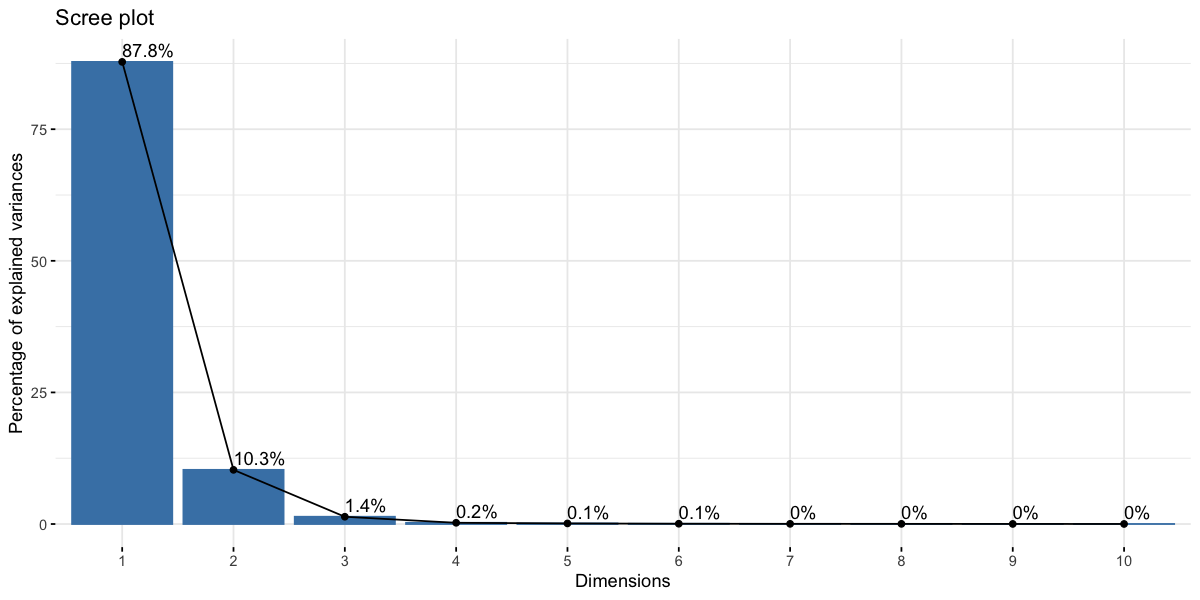

In [22]:
# PCA helps in identifying outlying samples for quality control and gives a feeling for the principal causes of 
# variation in a dataset

# Calculate principal components using transposed count data
pca <- prcomp(t(countdata))

options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(pca, addlabels = TRUE)

In [24]:
head(coldata)

,Subject_ID,Sample_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,AS_1,AS_1_C,F,B,NH,47,23.7,AS,C,Air
2,AS_1,AS_1_F,F,B,NH,47,23.7,AS,F,PGGLY
4,AS_1,AS_1_S,F,B,NH,47,23.7,AS,S,PGGLY
5,AS_2,AS_2_C,F,W,NH,19,19.5,AS,C,Air
6,AS_2,AS_2_F,F,W,NH,19,19.5,AS,F,PGGLY
8,AS_2,AS_2_S,F,W,NH,19,19.5,AS,S,PGGLY


In [25]:
# Make dataframe for PCA plot generation using first two components and the sample name
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], Sample_ID = colnames(countdata))

# Calculating percent of the variation that is captured by each principal component
pca_percent <- round(100 * pca$sdev^2/sum(pca$sdev^2), 1)

# Organize dataframe so we can color our points by burn condition
pca_df <- pca_df %>% 
    inner_join(coldata)
    #separate(SampleID, into = c("SubjectNo", "Condensate", "Burn_Condition"), sep = "_", remove = FALSE)

head(pca_df)

Joining with `by = join_by(Sample_ID)`


,PC1,PC2,Sample_ID,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,-85631.59,-79102.90,AS_1_C,AS_1,F,B,NH,47,23.7,AS,C,Air
2,-376797.37,-96811.89,AS_1_F,AS_1,F,B,NH,47,23.7,AS,F,PGGLY
3,19731.37,-46940.50,AS_1_S,AS_1,F,B,NH,47,23.7,AS,S,PGGLY
4,-40463.09,-48736.07,AS_2_C,AS_2,F,W,NH,19,19.5,AS,C,Air
5,155899.99,-18588.01,AS_2_F,AS_2,F,W,NH,19,19.5,AS,F,PGGLY
6,170558.52,-14029.99,AS_2_S,AS_2,F,W,NH,19,19.5,AS,S,PGGLY


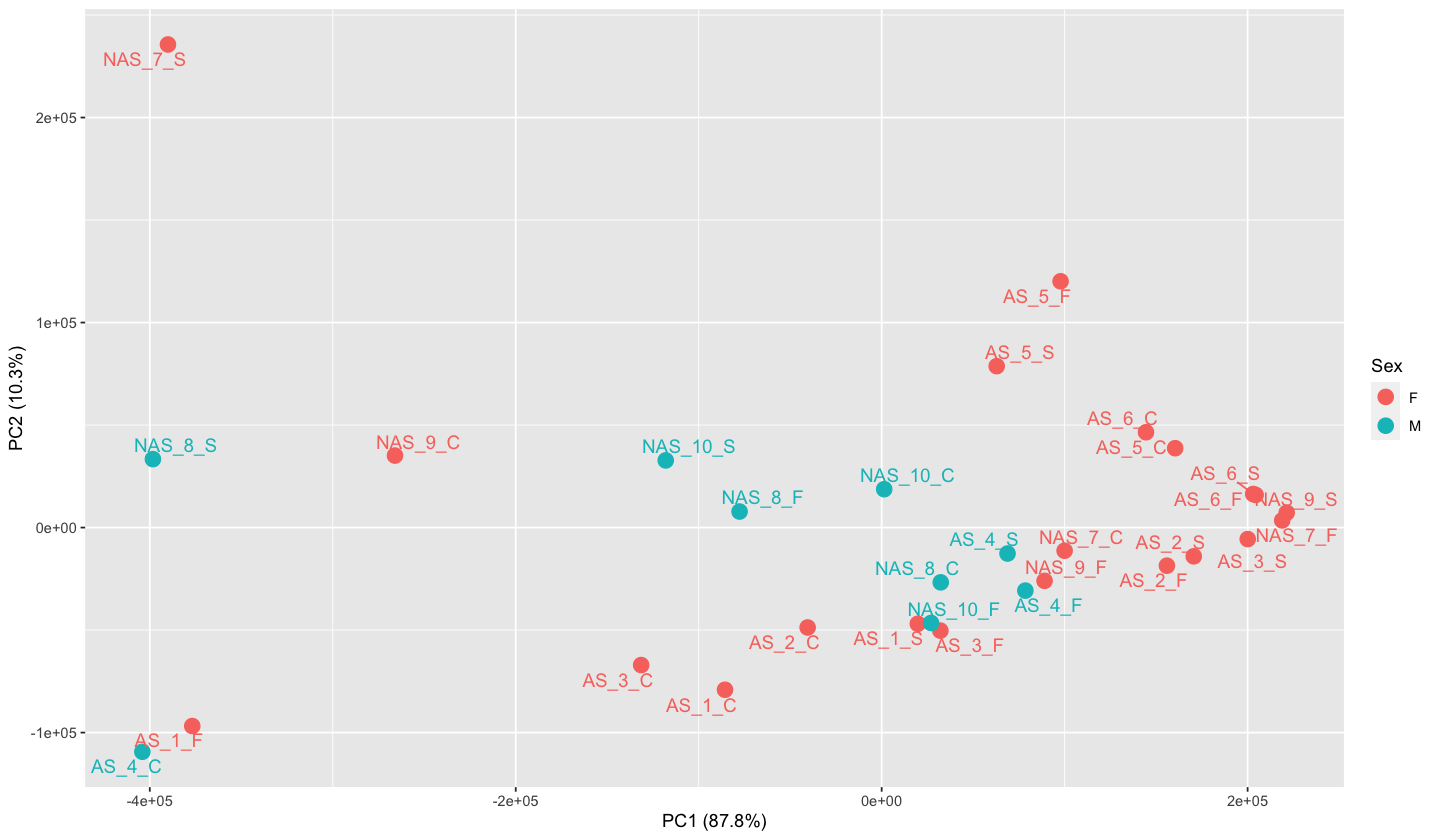

In [28]:
options(repr.plot.width=12, repr.plot.height=7) #changing size

# color by sex since that's a covariate we're interested in
ggplot(pca_df, aes(PC1, PC2, color = Sex)) +
  geom_point(size = 4) +
  geom_text_repel(aes(label = Sample_ID), size = 4) +
  labs(x = paste0("PC1 (",pca_percent[1],"%)"), y = paste0("PC2 (",pca_percent[2],"%)"))

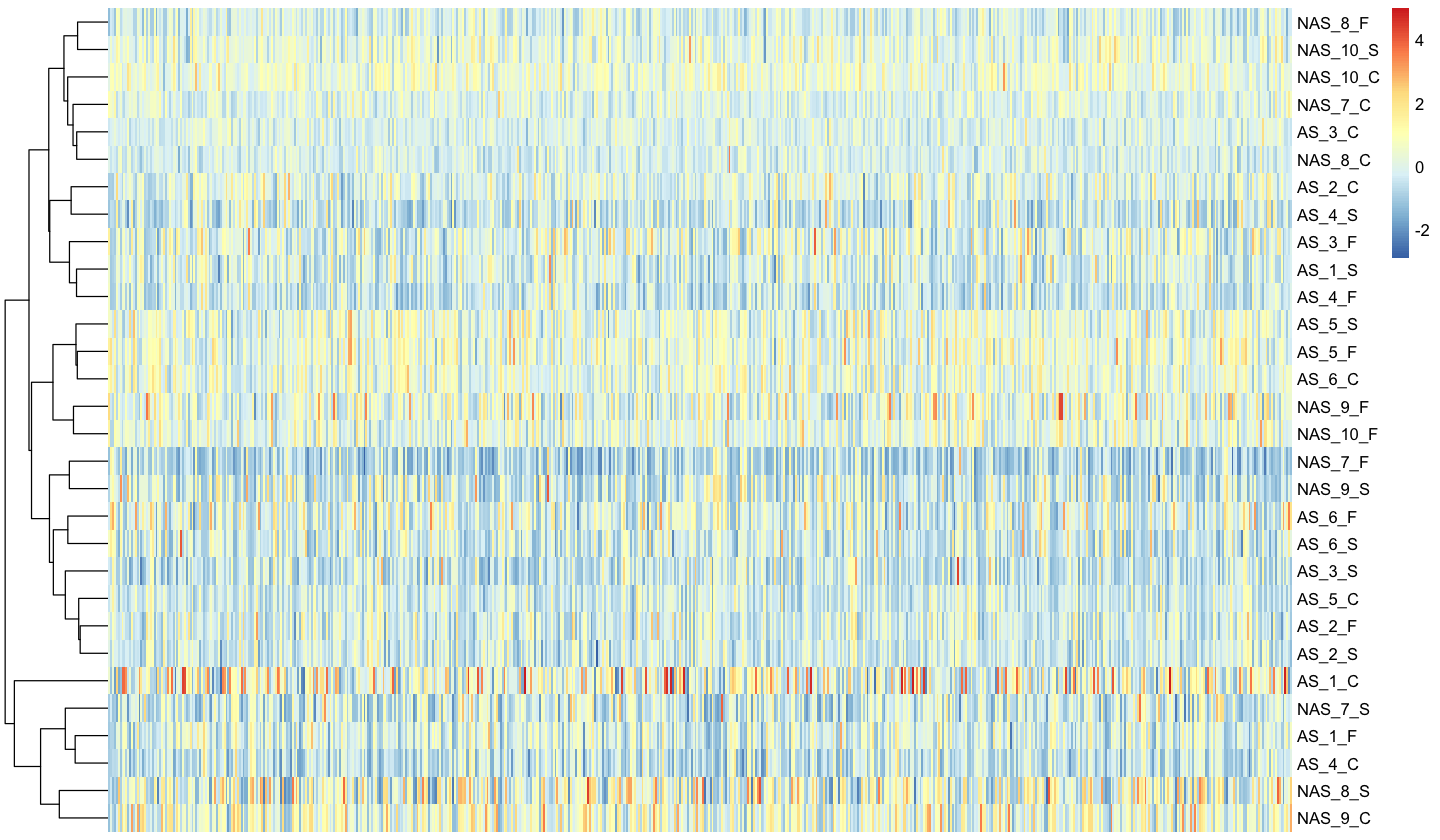

In [29]:
countdata_for_clustering <- t(countdata)

pheatmap(scale(countdata_for_clustering), 
         cluster_rows = TRUE, cluster_cols = FALSE, fontsize_col = 7, treeheight_row = 60, show_colnames = FALSE)

There were no clear sample outliers from PCA or hierarchical clustering, so now we'll use a quantitative approach. The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. source ADD!!!

In [32]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
gene_outliers = outlier_detection(pca)  

In [33]:
# getting length
length(gene_outliers)

[1] 0

# DESeq2 Experiment

In [35]:
# Starting with putting variables into factors
coldata$Disease_Status = factor(coldata$Disease_Status)
coldata$Exposure = factor(coldata$Exposure)
coldata$Sex = factor(coldata$Sex)

In [34]:
head(countdata)
head(coldata)

,AS_1_C,AS_1_F,AS_1_S,AS_2_C,AS_2_F,AS_2_S,AS_3_C,AS_3_F,AS_3_S,AS_4_C,⋯,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A4GALT,4108.5,2986,4169,3063.0,4008,3853,3457.0,4976,3506,3027,⋯,3045,3745.5,2825,3028,2884.5,5519,3161,3856.0,4939,3628
AADAC,2.0,14,5,10.5,25,13,37.0,7,19,10,⋯,32,26.5,32,30,47.5,28,70,82.0,12,69
ABCA13,232.5,94,85,76.0,298,260,191.0,95,362,120,⋯,60,179.5,134,30,84.5,110,349,313.5,95,161
ABHD17C,320.5,461,575,699.5,821,696,830.5,524,814,574,⋯,513,660.5,488,561,443.0,1025,801,791.0,1011,770
ABHD2,1631.5,1018,1104,1591.5,845,931,944.0,1052,698,794,⋯,508,789.0,1230,621,905.5,775,937,1245.0,1153,1347
ABRACL,1524.5,2717,2709,2341.5,2166,2155,2315.5,2982,1895,2652,⋯,3067,2797.0,2889,4027,3633.5,3042,2136,2814.5,2893,3029


,Subject_ID,Sample_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,AS_1,AS_1_C,F,B,NH,47,23.7,AS,C,Air
2,AS_1,AS_1_F,F,B,NH,47,23.7,AS,F,PGGLY
4,AS_1,AS_1_S,F,B,NH,47,23.7,AS,S,PGGLY
5,AS_2,AS_2_C,F,W,NH,19,19.5,AS,C,Air
6,AS_2,AS_2_F,F,W,NH,19,19.5,AS,F,PGGLY
8,AS_2,AS_2_S,F,W,NH,19,19.5,AS,S,PGGLY


In [37]:
# All values should be integers (DESeq2 requires integer count values), so we'll need to convert values here if they aren't
# Let's check the class of the values:
sapply(countdata, class)

AS_1_C    AS_1_F    AS_1_S    AS_2_C    AS_2_F    AS_2_S    AS_3_C    AS_3_F 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
   AS_3_S    AS_4_C    AS_4_F    AS_4_S    AS_5_C    AS_5_F    AS_5_S    AS_6_C 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
   AS_6_F    AS_6_S   NAS_7_C   NAS_7_F   NAS_7_S   NAS_8_C   NAS_8_F   NAS_8_S 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
  NAS_9_C   NAS_9_F   NAS_9_S  NAS_10_C  NAS_10_F  NAS_10_S 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric"

We're intersted in comparing... 
- non-asthmatics to asthmatics
- exposure groups (control, freebase nicotine, and nicotine salt users)
- sex

> Design #1: Disease Status
> 
> Design #2: Disease Status + Exposure

In [36]:
# Our design indicates that our count data is dependent on the exposure condition 
# (groups variable) and our factor of unwanted variation, and we have specified 
# that there not be an intercept term through the use of '~0'

dds <- DESeqDataSetFromMatrix(countData = countdata, 
                              colData = coldata,
                              design = ~Disease_Status) # Setting up the statistical formula (see below)
# View what the experiment contains
dds

ERROR: Error in DESeqDataSet(se, design = design, ignoreRank): some values in assay are not integers
